In [5]:
# 7/22/21: https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

# end cite


In [6]:
import json
import os
from os.path import join, exists

import pandas as pd
import matplotlib.pyplot as plt

from utils import load_models, transformers_bert_completions, split_gen
from utils_child import child_models
import config

{'best_metric': 2.406510353088379, 'best_model_checkpoint': './experiments/no_versioning/models/all/all/with_tags/checkpoint-5', 'epoch': 3.0, 'global_step': 6, 'is_hyper_param_search': False, 'is_local_process_zero': True, 'is_world_process_zero': True, 'log_history': [{'epoch': 0.5, 'learning_rate': 4.166666666666667e-05, 'loss': 4.1004, 'step': 1}, {'epoch': 0.5, 'eval_loss': 2.9395387172698975, 'eval_runtime': 4.4362, 'eval_samples_per_second': 2.254, 'step': 1}, {'epoch': 1.0, 'learning_rate': 3.3333333333333335e-05, 'loss': 3.525, 'step': 2}, {'epoch': 1.0, 'eval_loss': 2.988809108734131, 'eval_runtime': 4.194, 'eval_samples_per_second': 2.384, 'step': 2}, {'epoch': 1.5, 'learning_rate': 2.5e-05, 'loss': 3.0349, 'step': 3}, {'epoch': 1.5, 'eval_loss': 2.858211040496826, 'eval_runtime': 4.2719, 'eval_samples_per_second': 2.341, 'step': 3}, {'epoch': 2.0, 'learning_rate': 1.6666666666666667e-05, 'loss': 3.0689, 'step': 4}, {'epoch': 2.0, 'eval_loss': 2.7099664211273193, 'eval_runti

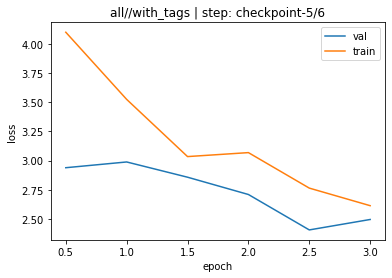

In [5]:

paths = [
    #split_gen.get_split_folder('child', 'Alex', config.model_dir),
    './experiments/no_versioning/models/all/all/',
]

has_tags_list = [
    True,
]

for path, tags in zip(paths, has_tags_list):

    tag_str =  "with_tags" if tags else "no_tags"

    with open(join(path, join(tag_str, 'trainer_state.json')), 'r') as f:

        gen_dict = json.load(f)
        this_history = gen_dict['log_history']

        epochs = []; losses = []

        for step_dict in this_history[:-1]: # Omit summary stats
            if 'eval_loss' not in step_dict: continue
            epochs.append(step_dict['epoch'])
            losses.append(step_dict['eval_loss'])

        train_epochs = []; train_losses = []
        for step_dict in this_history[:-1]: # Omit summary stats
            if 'loss' not in step_dict: continue
            train_epochs.append(step_dict['epoch'])
            train_losses.append(step_dict['loss'])

        print(gen_dict) # Because it's still on the debugging mode.

        this_step = gen_dict['best_model_checkpoint'].split('/')[-1]
        dataset_name = '/'.join(path.split('/')[-2:]) + f'/{tag_str} | step: {this_step}' + f"/{gen_dict['global_step']}"

    plt.title(f'{dataset_name}')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.plot(epochs, losses, label = 'val')
    plt.plot(train_epochs, train_losses, label = 'train')

    plt.legend(); plt.show()
